<a href="https://colab.research.google.com/github/pwilczewski/Fed_portfolio_analysis/blob/main/Open_source_analysis_of_the_Fed's_RMBS_portfolio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
As-of October 19th 2022, the Federal Reserve held nearly &#36;2.7 trillion of agency RMBS on its balance sheet. This position could be a material risk for taxpayers if the Fed needs to recapitalize its balance sheet to retain policy credibility. In 2022 the Fed posted its first operating loss in over a decade raising concerns about how the Fed plans to manage its capital position. Several publications have discussed the Fed's losses in detail:

*   [Fed on track for tens of billions in losses amid inflation fight (Reuters)](https://www.reuters.com/markets/us/fed-track-tens-billions-losses-amid-inflation-fight-2022-10-28/)
*   [Who owns the Fed's massive losses (The Hill / AEI)](https://thehill.com/opinion/finance/3532683-who-owns-the-feds-massive-losses/)
*   [An Analysis of the Interest Rate Risk of the Federal Reserve’s Balance Sheet (Federal Reserve)](https://www.federalreserve.gov/econres/notes/feds-notes/an-analysis-of-the-interest-rate-risk-of-the-federal-reserves-balance-sheet-part-2-20220715.html)


The primary source of losses is an interest rate mismatch between the Fed's assets and liabilities. Between 2008 and 2022 the Fed purchased a portfolio of long term fixed rate RMBS and funded these purchases using mostly floating rate reserves from commercial banks and overnight reverse repurchase agreements. Currently the income the Fed receives from its RMBS portfolio is below its cost of funds. Although the Fed has begun running off its assets the pace of this runoff will determine the timing and magnitude of future losses.

In this notebook and the accompanying [github repo](https://github.com/pwilczewski/Fed_portfolio_analysis) I provide an open source analysis of the Fed's RMBS portfolio. First I summarize the data used in this analysis. Next I forecast the portfolio cash flows to measure the expected rate of runoff. Then I estimate the value of the portfolio and its effective duration. Finally I project the taxpayer liability that would result from recapitalizing future operating losses.

My background is as a quantitative researcher building models for a variety of assets including RMBS, CMBS and CLOs. I am currently working independently on a variety of projects in ML/AI, open source and education - you can find me on [Twitter](https://twitter.com/indiequant).

# Analysis summary

At current interest rates the Fed's agency RMBS portfolio will be a large contributor to operating losses for years to come. Over the next twelve months I estimate this portfolio will produce a \$50 billion loss. Currently the Fed plans to account for these losses by using deferred assets and paying down these assets after returning to profitability. However given the Fed's goals of balance sheet runoff and a prolonged period of higher rates, a return to profitability appears many years away.

| RMBS portfolio results |  | 
| --- | --- |
| **Face amount** | \$2.7T |
| **Net present value** | \$2.4T |
| **Price** | 89.02 |
| **Effective duration** | 6.72 |
| **1-year net income** | -\$50B |
| **Cumulative net income** | -\$360B |

# 1. Data summary
For this analysis I downloaded CUSIP-level data for the Fed's 10/19/2022 RMBS portfolio from [SOMA holdings](https://www.newyorkfed.org/markets/soma-holdings). This portfolio contains 31,135 CUSIPs in total. However the vast majority of these CUSIPs have small balances, the 2,130 largest CUSIPs comprise 95% of the portfolio's balance. For simplicity I selected just these CUSIPs for analysis. Then I processed this data and augmented it with supplementary data from the issuing agency where necessary to construct the data set for projecting cash flows.

In [ ]:
%%capture
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
!pip install QuantLib
import QuantLib as ql
from os import path
import sys

if not path.exists('Fed_portfolio_analysis/processed_data.csv'):
  !git clone https://github.com/pwilczewski/Fed_portfolio_analysis

sys.path.append("/content/Fed_portfolio_analysis")
import openRMBS as ombs

mbs_data = pd.read_csv("Fed_portfolio_analysis/processed_data.csv", index_col=0)

## Portfolio summary

In [ ]:
ombs.data_summary(mbs_data)



# of CUSIPs in sample    2130
Sample balance         $2.56T
Percent of total         95.0


         note_rate       coupon          age         term      curr_bal
count  2130.000000  2130.000000  2130.000000  2130.000000  2.130000e+03
mean      3.491302     2.764085    40.898592   315.944131  1.199755e+09
std       0.818091     0.874916    42.499358    72.789866  3.135509e+09
min       1.978000     1.500000     0.000000   113.000000  6.748413e+07
25%       2.902250     2.000000    12.000000   345.000000  1.073476e+08
50%       3.369500     2.500000    24.000000   353.000000  1.925095e+08
75%       3.930000     3.500000    49.000000   357.000000  6.485768e+08
max       6.567000     6.000000   206.000000   360.000000  3.057593e+10


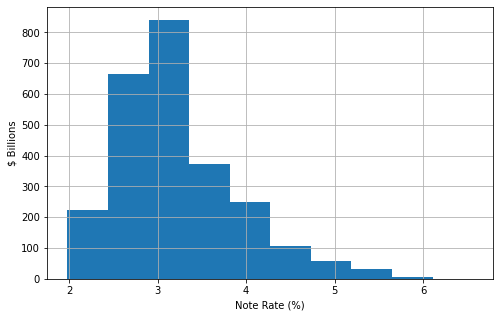

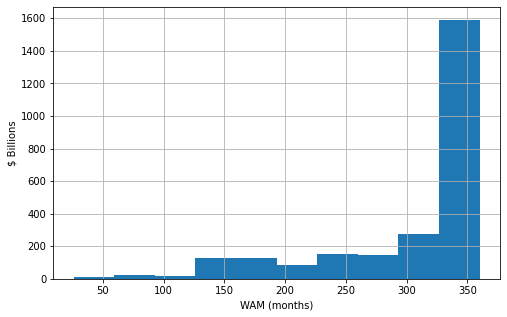

In [ ]:
ombs.exploratory_plots(mbs_data)

## Yield curve summary
For this analysis I use the Treasury yield curve for discounting. I calculate discount factors and forward rates using the [treasury par yield curve](https://home.treasury.gov/resource-center/data-chart-center/interest-rates/TextView?type=daily_treasury_yield_curve&field_tdr_date_value=2022) as-of 10/19/2022. I exclude the 20-year maturity due to ongoing concerns about liquidity for those instruments.

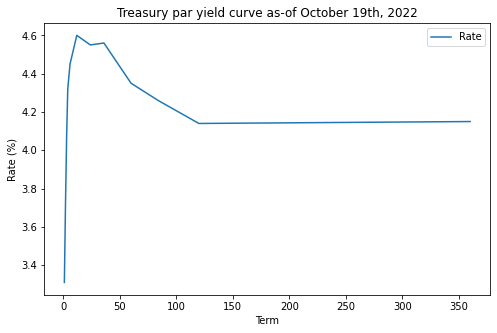

In [ ]:
asof_date = ql.Date(19, 10, 2022)
term_points = [1, 2, 3, 4, 6, 12, 24, 36, 60, 84, 120, 360]
rates = [3.31, 3.72, 4.07, 4.32, 4.45, 4.60, 4.55, 4.56, 4.35, 4.26, 4.14, 4.15]
maturities = [ql.Period(t, ql.Months) for t in term_points]
base_curve = ombs.TreasuryParCurve(maturities, rates, asof_date)
fwd_rates = base_curve.fwd_rates(range(0,360))

ombs.plot_par_rates(term_points, rates, asof_date)

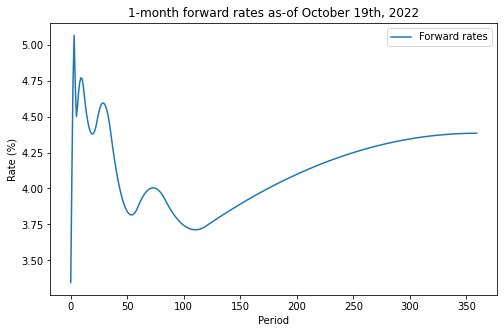

In [ ]:
ombs.plot_fwd_rates(fwd_rates, asof_date)

# 2. Runoff analysis
Given the complexity of RMBS I make a number of simplifying assumptions to keep the analysis tractable. First I assume each security is homogenous in its contractual features such as note rate, term and remaining maturity. Then I use the weighted average value of each to forecast the scheduled principal and interest payments. Next I assume a static annual prepayment rate (CPR) of 6% for all securities. While this CPR is historically low for agency RMBS it is consistent with [recently observed prepayment rates](https://capitalmarkets.fanniemae.com/media/23091/display). As-of 10/20/2022 the [primary mortgage market survey rate](https://fred.stlouisfed.org/series/MORTGAGE30US) on a new 30-year residential mortgage was 6.94%. The average note rate of every RMBS in the subset of CUSIPs analyzed is below the prevailing 30-year mortgage rate. As a result most of these borrowers have a strong financial incentive not to prepay. While mortgage rates remain near current levels it is reasonable to expect prepayments on this portfolio to remain at low levels.

Using the scheduled principal payments and prepayments I forecast the total amount of principal runoff in each month. Then I calculate the number of months it will take for 50\% and 95\% of the RMBS portfolio to run off. I assume scheduled payments and prepayments are the only sources of runoff for this portfolio. Currently the Fed has indicated they have no plans to consider selling securities. Additionally I have rescaled all portfolio and runoff balances to reflect the full \$2.7T portfolio.

In [ ]:
mbs_cf = ombs.forecast_cashflows(mbs_data, cpr=6)

## Forecast results

I predict an average runoff of &#36;19.6 billion over the next year and a portfolio portfolio half-life of 85 months.





1-year average runoff:  19.6 billion
5-year average runoff:  17.08 billion




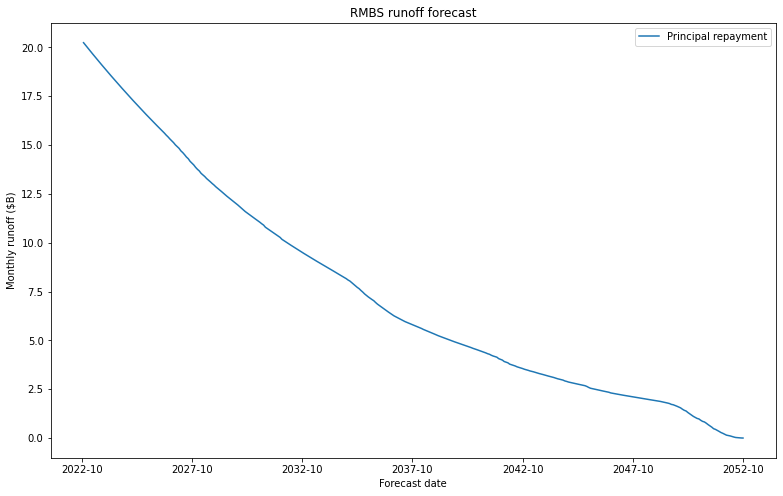

In [ ]:
ombs.plot_runoff(mbs_cf, "RMBS runoff forecast", asof_date)



Months to 50% runoff:  85
Months to 95% runoff:  273
Date of 50% runoff:  2029-11
Date of 95% runoff:  2045-07




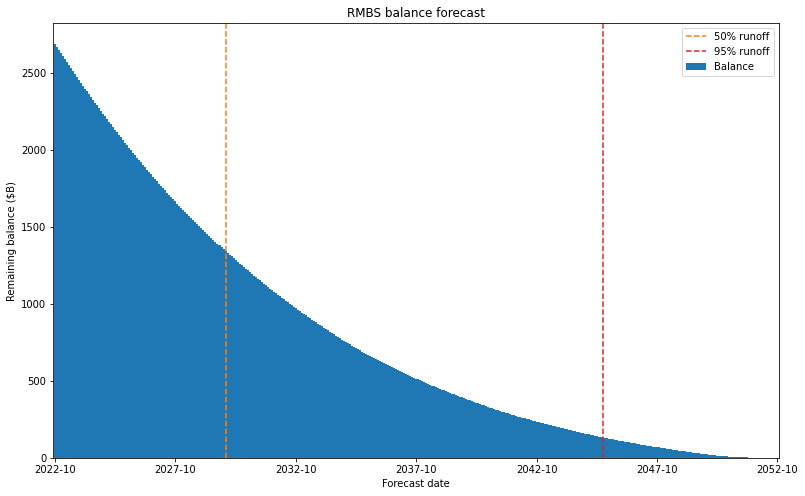

In [ ]:
ombs.plot_balances(mbs_cf, "RMBS balance forecast",asof_date)

# 3. Valuation and risk analysis

Given the cash flow forecast I calculate the net present value of each security using the treasury yield curve for discounting. Here I consider only static valuation since the median note rate in the portfolio is over 3\% below prevailing mortgage rates. As a result the prepayment option has little value for most borrowers and static valuation is a good proxy for a full Monte Carlo valuation.

I calculate the net present value of this portfolio is 2,394 billion or 89.02 of the par value. Assuming the Fed's liabilities are valued at par then the RMBS portfolio contributes 295 billion to the capital shortfall on the Fed's balance sheet.



Average price           89.02
Balance outstanding  $2690.0B
Economic value       $2394.6B
Capital shortfall    $-295.4B




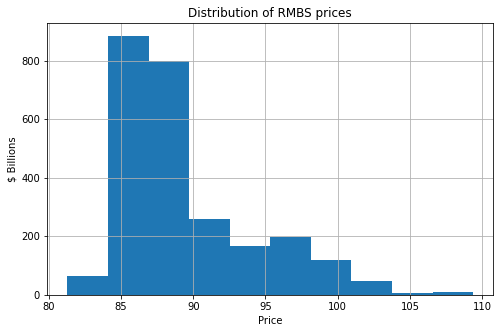

In [ ]:
base_df = base_curve.calculate_df(range(1,361))
mbs_prices = ombs.static_pricing(mbs_data, cpr=6, discount_factors=base_df)
ombs.analysis_summary(mbs_prices)

## Risk characteristics
I evaluate the interest rate risk of the Fed's portfolio by calculating the effective duration and DV01. The effective duration measures the sensitivity of price to interest rate changes for each security. I calculate is using +/-25 basis point shocks to the treasury par curve. Then I calculate the DV01 by estimating the change in portfolio value for each 1 bp change in rates.

I estimate the effective duration of the portfolio is 6.72 and the DV01 is &#36;1.53 billion.



Average duration: 	 6.72
Portfolio DV01: 	 $1.53B




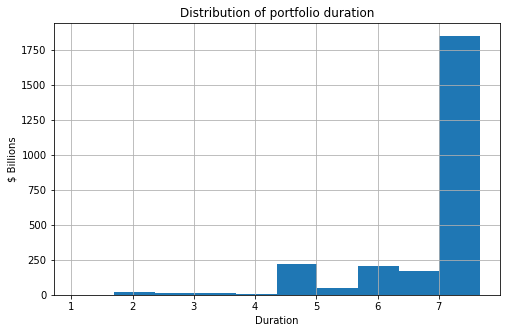

In [ ]:
curve_up25 = ombs.TreasuryParCurve(maturities, [r+0.25 for r in rates], asof_date)
curve_down25 = ombs.TreasuryParCurve(maturities, [r-0.25 for r in rates], asof_date)
prices_up25 = ombs.static_pricing(mbs_data, 6, curve_up25.calculate_df(range(1,361)))
prices_down25 = ombs.static_pricing(mbs_data, 6, curve_down25.calculate_df(range(1,361)))
duration = (prices_down25['price'] - prices_up25['price'])/(0.5*mbs_prices['price']/100)

ombs.plot_durations(mbs_prices, duration)

# 4. Interest rate gap analysis

The Fed has funded its purchases of RMBS primarily through collecting bank reserves and conducting reverse repurchase agreements. Both sources of funding require the Fed to pay interest - Interest on Bank Reserves ([IORB](https://fred.stlouisfed.org/series/IORB)) and Overnight Reverse Repurchase agreements ([ON/RRP](https://fred.stlouisfed.org/series/RRPONTSYAWARD)). These rates are closely correlated with the yields on short term treasury bills. In this analysis I assume the Fed's net cost of funding is equal to the 1 month treasury forward rate. This assumption sets a reasonable floor for the Fed's cost of funds. If IORB were to fall below short term treasury bill rates then banks would withdraw reserves and buy t-bills.

Over the next year I forecast the net income on this portfolio will be -50 billion. The portfolio's net income will continue to be negative in every month until May 2052. In total I project cumulative net income will be -360 billion through contractual maturity.



1-year net income: -50.2 billion
Total net income:  -360.5 billion




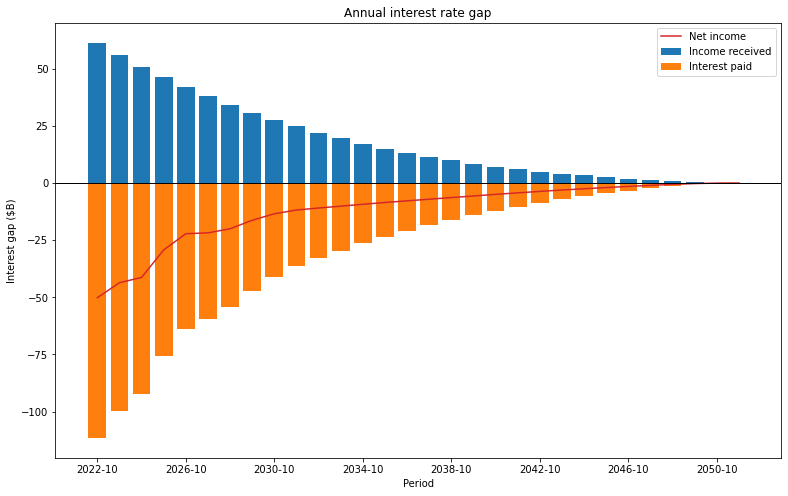

In [ ]:
interest_gap = ombs.static_gap(mbs_data, 6, fwd_rates)
ombs.plot_gap(interest_gap, asof_date)